In [86]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp

# Set initial concentrations of all species in the MAPK model (Unit: nM)
dir_initial_concentrations = {
    "RAS": 18900,
    "RAF": 66.4,
    "RAFp": 1000.0,
    "MEK": 36500,
    "MEKp": 1000.0,
    "MEKpp": 1000.0,
    "ERK": 34900,
    "ERKp": 1000.0,
    "ERKpp": 1000.0,
    "PP2A": 150,
    "MKP3": 2.4
}

# Define parameter estimates, as derived from literature (Geoffrey et all, A decompositional approach to parameter estimation in pathway modeling: a case study of \\
# the Akt and MAPK pathways and their crosstalk)
dir_param_estimates = {
    "D": [0.09, 5.6, 0.45, 5.17, 0.4, 0.089, 30, 0.0308, 32],
    "Km": [50, 7200, 1250, 24500, 4316, 52000, 160, 55000, 60]
}

# Set generation rates, 0.1 are arbitraty values
dir_generation_rates = {
    "mRAS": 0.1,
    "mRAF": 0.1,
    "mRAFp": 0.1,
    "mMEK": 0.1
}

# Set parameter values for parameters that are not present in the Geoffrey et al. paper ("A decompositional approach to parameter estimation in pathway modeling: a case study of \\
# the Akt and MAPK pathways and their crosstalk")
unknown_parameters = [10000.1, 5000.1, 400.1, 16151510.1, 0151.1, 000.1]
#unknown_parameters = [1, 1, 1, 1, 1, 1]

# Flatten the initial concentrations for use in the ODE solver
initial_concentrations = list(dir_initial_concentrations.values())

# Ensure there are 11 initial conditions corresponding to 11 ODEs
assert len(initial_concentrations) == 11, "Mismatch in the number of initial conditions."

# Define function containing the ODEs for the MAPK model
def get_ODEs(t, y, generation_rates, param_estimates, unknown_parameters):
    """
    Compute the ODEs for the MAPK model.
    """
    RAS, RAF, RAFp, MEK, MEKp, MEKpp, ERK, ERKp, ERKpp, PP2A, MKP3 = y

    # Unpack generation rates and parameters
    mRAS, mRAF, mRAFp, mMEK = generation_rates.values()
    D = param_estimates['D']
    Km = param_estimates['Km']
    k0, k1, k2, k3, k4, k5 = unknown_parameters

    # Reactions
    R0 = mRAS * (k0 / (k0 + ERKp)) * (k1 / (k1 + ERKpp))
    R1 = mRAFp * (k2 / (k2 + ERKp)) * (k3 / (k3 + ERKpp))
    R2 = mMEK * (k4 / (k4 + ERKp)) * (k5 / (k5 + ERKpp))

    F_D0 = RAF * RAS * (D[0] / (Km[0] + RAF))
    F_D1 = MEK * RAFp * (D[1] / (Km[1] + MEK))
    F_D2 = MEKp * PP2A * (D[2] / (Km[2] + MEKp))
    F_D3 = MEKp * RAFp * (D[3] / (Km[3] + MEKp))
    F_D4 = MEKpp * PP2A * (D[4] / (Km[4] + MEKpp))
    F_D5 = ERK * MEKpp * (D[5] / (Km[5] + ERK))
    F_D6 = ERKp * MKP3 * (D[6] / (Km[6] + ERKp))
    F_D7 = ERKp * MEKpp * (D[7] / (Km[7] + ERKp))
    F_D8 = ERKpp * MKP3 * (D[8] / (Km[8] + ERKpp))

    # Set degeneration rate constant g
    #g = 0.01
    g = 0.0002

    # ODEs
    dRAS = R0 - g * RAS
    dRAF = mRAF - F_D0 - g * RAF
    dRAFp = R1 + F_D0 - g * RAFp
    dMEK = R2 + F_D2 - F_D1 - g * MEK
    dMEKp = F_D1 - F_D2 + F_D4 - F_D3 - g * MEKp
    dMEKpp = -F_D4 + F_D3 - g * MEKpp
    dERK = F_D6 - F_D5 - g * ERK
    dERKp = F_D5 + F_D8 - F_D7 - F_D6 - g * ERKp
    dERKpp = F_D7 - F_D8 - g * ERKpp
    dPP2A = 0
    dMKP3 = 0

    print("The change in RAS concentration is: {}".format(dRAS))

    return [dRAS, dRAF, dRAFp, dMEK, dMEKp, dMEKpp, dERK, dERKp, dERKpp, dPP2A, dMKP3]

# Define a function to find the steady state by integrating the ODEs over time
def find_steady_state(unknown_parameters):
    # Time span for the integration
    t_span = (0, 100000)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    
    # Solve the ODEs using BDF or RK45 integration method
    sol = solve_ivp(
        get_ODEs, 
        t_span, 
        initial_concentrations, 
        args=(dir_generation_rates, dir_param_estimates, unknown_parameters),
        t_eval=t_eval,
        method='BDF',
        #method='RK45',
        vectorized=False
    )

    print("The solution obtained with solve_ivp is: {}".format(sol))

    # Check for success
    if sol.success:

        """
        tail = sol.y[:, -20:]
        ss_range_max = np.max(tail, axis=1)
        ss_range_min = np.min(tail, axis=1)

        print("Steady state range:", ss_range_min, ss_range_max)
        if np.allclose(ss_range_min, ss_range_max, rtol=1e-1):
            print("Steady state reached.")
            steady_state = sol.y[:, -1]
            return steady_state

        else:
            print("Steady state not reached.")
            return None"""
        
        # Steady state will be the last values of the solution
        steady_state = sol.y[:, -1]
        return steady_state, sol
    else:
        print("ODE solver failed:", sol.message)
        return None
    
# Convert the solution to a pandas DataFrame
def solution_to_dataframe(sol):
    # Time points are stored in sol.t
    time_points = sol.t
    # The solution array (species concentrations at each time point) is stored in sol.y
    concentrations = sol.y
    
    # Create a DataFrame with time as the index
    df = pd.DataFrame(concentrations.T, columns=dir_initial_concentrations.keys(), index=time_points)
    df.index.name = 'Time'
    return df


# Find the steady state
steady_state = find_steady_state(unknown_parameters)
if steady_state is not None:
    print("Steady state concentrations:", steady_state)


The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042392026435103
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.704242046524864
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.704242102953878
The change in RAS concentration is: -3.7042421026631103
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042421028512535
The change in RAS concentration is: -3.7042413063198985
The change in RAS concentration is: -3.7042413063340742
The change in RAS concentration is: -3.7042405098108953
The change in RAS concentration is: -3.70424050982

In [87]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import qmc
from itertools import product

import datetime


# Set number fo samples and number of dimensions (parameters). The number of samples is the total number of samples over the parameter space as a whole
n_samples = 100
n_params = 6

# Create Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=n_params)

# Generate samples
sample = sampler.random(n=n_samples)

a1, a2, a3, a4, a5, a6 = 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
b1, b2, b3, b4, b5, b6 = 1000, 1000, 1000, 1000, 1000, 1000


# Define the lower and upper bounds for each parameter
lower_bounds = np.array([a1, a2, a3, a4, a5, a6])
upper_bounds = np.array([b1, b2, b3, b4, b5, b6])

# Scale the sample to your desired ranges
scaled_sample = qmc.scale(sample, lower_bounds, upper_bounds)


# Define function that calculates the steady states
def find_steady_states_for_parameters(k_values): 
    unknown_parameters = k_values
    steady_state, sol = find_steady_state(unknown_parameters)
    return steady_state, sol

# Store steady states
steady_states = []

solutions = {}

# Iterate over parameter combinations
for params in scaled_sample:
    k_values = tuple(params)
    print("The k-values in this iteration are: {}".format(k_values))
    steady_state, sol = find_steady_states_for_parameters(k_values)

    now = datetime.datetime.now()
    print("time, k_values, steady_state -------------------")
    print(f"{now}: k_values = {k_values}, steady_state = {steady_state}")
    print("--------------------")

    if steady_state is not None:
        print(f"Steady state found for k_values = {k_values}")	
        solutions[k_values] = sol
        steady_states.append(steady_state)

# Analyze the steady states
unique_steady_states = np.unique(np.round(steady_states, decimals=5), axis=0)
print(f"Number of unique steady states found: {len(unique_steady_states)}")


The k-values in this iteration are: (784.8167317982138, 418.7500151917483, 293.97751802893566, 58.556911018564115, 680.7557318286443, 144.28275361358885)
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.767019181131475
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670214711692953
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215276040397
The change in RAS concentration is: -3.7670215273593715
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.7670215274956846
The change in RAS concentration is: -3.767020883092734
The chan

The change in RAS concentration is: -3.766933923408793
The change in RAS concentration is: -3.766933922781916
The change in RAS concentration is: -3.766933922782478
The change in RAS concentration is: -3.7669339227823815
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.766908549273417
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669084932890198
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085497231074
The change in RAS concentration is: -3.7669085494778685
The change in RAS concentration is: -3.7669085496142376
The change in RAS concentration is: -3.7669085496142

In [88]:

solutions_dfs = []

for k_values, sol in solutions.items():
    df_solution = solution_to_dataframe(sol)
    solutions_dfs.append(df_solution)

#df_solution = solution_to_dataframe(sol)
#display(df_solution)

In [89]:
species_list = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp']


dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3'])
['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']
dict_keys(['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ER

<Figure size 1000x600 with 0 Axes>

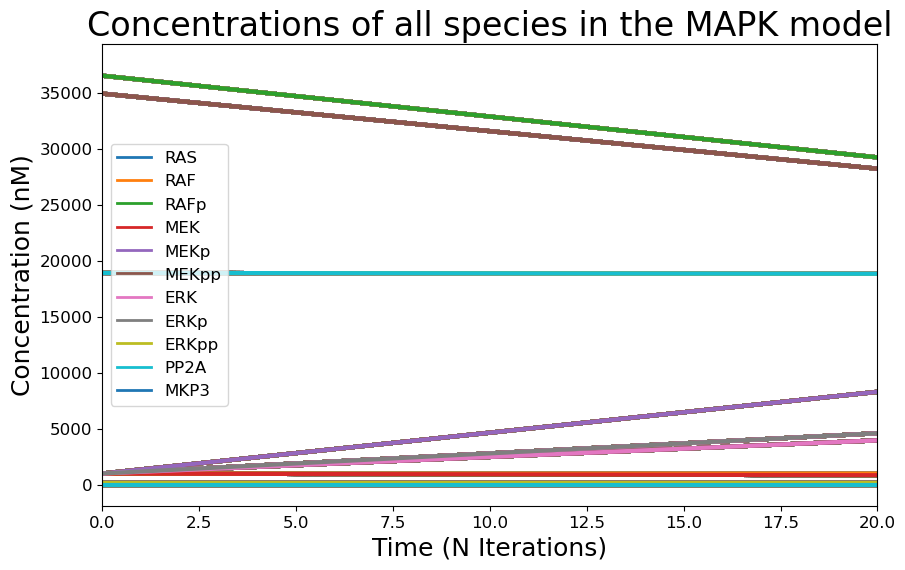

In [95]:
import matplotlib.pyplot as plt

# Plot the solution
fig = plt.figure(figsize=(10, 6))

def plot_concentrations(i, df_solution, species_list=species_list):
    print(dir_initial_concentrations.keys())
    print(species_list)
    for species in species_list:
        if i == 0:
            ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=2)
        else:
            ax = plt.plot(df_solution.index, df_solution[species], linewidth=3)#, ylim=[0,40000])#, thickness=2)
        #plt.xlim(0, 15000)
        plt.xlim(0,20)
        plt.title("Concentrations of all species in the MAPK model", fontsize=24)
        plt.xlabel("Time (N Iterations)", fontsize=18)
        plt.ylabel("Concentration (nM)", fontsize=18)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)




# We plot all of the solutions of all species in a single plot

species_list_all_changeable = ['RAS', 'RAF', 'RAFp', 'MEK', 'MEKp', 'MEKpp', 'ERK', 'ERKp', 'ERKpp', 'PP2A', 'MKP3']

fig = plt.figure(figsize=(10, 6))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations(i, df_solution, species_list_all_changeable)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()


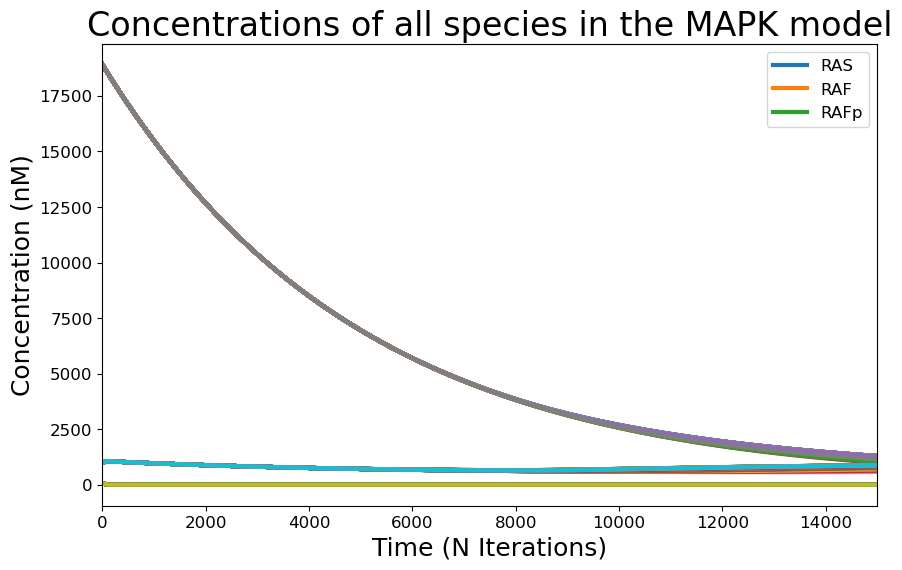

In [91]:
RAS_and_RAF = ['RAS', 'RAF', 'RAFp']

fig = plt.figure(figsize=(10, 6))
for i, df_solution in enumerate(solutions_dfs):
    plot_concentrations(i, df_solution, RAS_and_RAF)
#plot_concentrations(df_solution)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# We plot one of the solutions (randomly)

fig = plt.figure(figsize=(10, 6))
plot_concentrations(0, solutions_dfs[50])
plt.legend(fontsize=12)
plt.plot()

In [ ]:
# For one of the species, we plot all solutions in a single plot

def plot_concentration_single_species(df_solution, species):
    ax = plt.plot(df_solution.index, df_solution[species], label=species, linewidth=1)#, ylim=[0,40000])#, thickness=2)
    plt.xlim(0, 15000)
    plt.title("Concentrations of all species in the MAPK model", fontsize=24)
    plt.xlabel("Time (N Iterations)", fontsize=18)
    plt.ylabel("Concentration (nM)", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

In [ ]:
plot_concentration_single_species(solutions_dfs[0], "ERKpp")

In [ ]:
print(unique_steady_states)
type(unique_steady_states)
print(len(unique_steady_states))
print(unique_steady_states[1])

In [ ]:
import matplotlib.pyplot as plt

for species in dir_initial_concentrations.keys():
    plt.figure()
    plt.hist(unique_steady_states[:, list(dir_initial_concentrations.keys()).index(species)], bins=50)
    plt.title(species, fontsize=24)
    plt.xlabel("Concentration (nM)", fontsize=18)
    plt.ylabel("Number of simulations", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#plt.hist(unique_steady_states[:, 5], bins=50)



In [ ]:
import matplotlib.pyplot as plt


# Leave out the fixed species (PP2A and MKP3) from the analysis
unique_steady_states_non_fixed = unique_steady_states[:, :-2]
dir_initial_concentrations_non_fixed = {k: v for k, v in dir_initial_concentrations.items() if k not in ["PP2A", "MKP3"]}

for species in dir_initial_concentrations_non_fixed.keys():

    # Normalize steady state by species


    # Normalize the steady states
    steady_states_normalized = unique_steady_states_non_fixed[:, species] / np.max(unique_steady_states_non_fixed[:, species], axis=0)

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    #plt.figure()
    plt.hist(steady_states_normalized[:, list(dir_initial_concentrations.keys()).index(species)], bins=50, color=colors)
    plt.title(species)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Leave out the RAF and fixed species (PP2A and MKP3) from the analysis
unique_steady_states_non_fixed = unique_steady_states[:, [0, 2, 3, 4, 5, 6, 7, 8]]
dir_initial_concentrations_non_fixed = {k: v for k, v in dir_initial_concentrations.items() if k not in ["PP2A", "MKP3", "RAF"]}	

# Normalize the steady states for each species individually, using min-max normalization

#steady_states_normalized = unique_steady_states_non_fixed / np.max(unique_steady_states_non_fixed, axis=0)

# Define the colors for the species
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plotting all species in a single histogram
plt.figure(figsize=(10, 6))

for i, species in enumerate(dir_initial_concentrations_non_fixed.keys()):
    plt.hist(steady_states_normalized[:, i], bins=50, color=colors[i % len(colors)], alpha=0.5, label=species)

plt.title("Normalized Steady States for Each Species")
plt.xlabel("Normalized Concentration")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Leave out the RAF and fixed species (PP2A and MKP3) from the analysis
unique_steady_states_non_fixed = unique_steady_states[:, [0, 5, 6, 7]]
dir_initial_concentrations_non_fixed = {k: v for k, v in dir_initial_concentrations.items() if k not in ["PP2A", "MKP3", "RAF", "RAFp", "MEK", "MEKp","ERKpp"]}		

# Normalize the steady states
steady_states_normalized = unique_steady_states_non_fixed / np.max(unique_steady_states_non_fixed, axis=0)

# Define the colors for the species
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plotting all species in a single histogram
plt.figure(figsize=(10, 6))

for i, species in enumerate(dir_initial_concentrations_non_fixed.keys()):
    plt.hist(steady_states_normalized[:, i], bins=50, color=colors[i % len(colors)], alpha=0.5, label=species)

plt.title("Normalized Steady States for Each Species")
plt.xlabel("Normalized Concentration")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Leave out the RAF and fixed species (PP2A and MKP3) from the analysis
unique_steady_states_non_fixed = unique_steady_states[:, [0, 2, 3, 4, 5, 6, 7, 8]]
dir_initial_concentrations_non_fixed = {k: v for k, v in dir_initial_concentrations.items() if k not in ["PP2A", "MKP3", "RAF"]}	

# Normalize the steady states applying min-max normalization
steady_states_normalized = unique_steady_states_non_fixed / np.max(unique_steady_states_non_fixed, axis=0)

# Define the colors for the species
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plotting all species in a single histogram
plt.figure(figsize=(10, 6))

for i, species in enumerate(dir_initial_concentrations_non_fixed.keys()):
    plt.hist(steady_states_normalized[:, i], bins=50, color=colors[i % len(colors)], alpha=0.5, label=species)

plt.title("Normalized Steady States for Each Species")
plt.xlabel("Normalized Concentration")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()